# Decode against a 1s preodor baseline period, within a trial type (to see if trial-type decoding is being driven by changes in CS+ representation, CS-, or both)

In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_vs_baseline_vhpc'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

Unable to restore variable 'add_significance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'combine_train_test_patterns', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_decoding_combined_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'do_test_within_beta', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'sig_vs_chance', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_all_animals_vars', ignoring (use %store -d to forget!)
('The error was:', <type 'exceptions.KeyError'>)
Unable to restore variable 'load_cellreg', ignoring

In [12]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [13]:
expo_animals = 'c3m1', 'c3m2', 'c3f3', 'c10m8'
pre_animals = 'c3m1', 'c3m2', 'c3f3', 'c10m8'
post_animals = '90','90_475','91','93_500','93_580','93_720','93_810','c3m1', 'c3m2', 'c3f3', 'c10m8'

In [14]:
sessions = 'expo', 'pre', 'post'

In [15]:
for sess in 'pre', 'post':

    exec("patterns_tb_%s = dict(zip(%s_animals, [ut.load_variable('patterns_tb',\
                                                           '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))
    exec("labels_%s = dict(zip(%s_animals, [ut.load_variable('labels',\
                                                         '../%%s/%s/notebooks/autorestore/decoding_around_onset/'%%ani)\
                                                  for ani in %s_animals]))"%(sess, sess, sess, sess))

In [16]:
#have to extract 4_odor_expo varibles differently from that used above
patterns_tb_expo = dict(zip(expo_animals,
                                [ut.load_variable('patterns_tb','../%s/4_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

labels_expo = dict(zip(expo_animals,
                                [ut.load_variable('labels','../%s/4_odor_expo/notebooks/autorestore/decoding_around_onset'%ani)
                                                  for ani in expo_animals]))

In [17]:
delta_t0 = 1

t_start0 = -5  # sec
t_stop0 = 9  # sec

In [6]:
import h5py

def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in patterns.keys()])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)
        
def load_cellreg(animal, filename='pre_vs_post.mat', keys=['pre', 'post']):
    with h5py.File('../%s/data/%s'%(animal, filename), 'r') as f:
        g = np.r_[f['cell_registered_struct']['cell_to_index_map']]
        cellreg_dict = {k:g[i][np.where(np.prod([gg>0 for gg in g], 0))[0]].astype(int)-1
                        for i, k in enumerate(keys)}
    return cellreg_dict

In [7]:
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def do_test_within_beta(patterns_train,patterns_test, labels_train, labels_test, relabel=None, n_cells=None):
    
    if relabel is not None:
        labels_train = np.r_[[relabel[l] for l in labels_train]]
        labels_test = np.r_[[relabel[l] for l in labels_test]]
    else:
        labels_train = labels_train
        labels_test = labels_test
    
    if n_cells is None:
        cells = list(range(patterns_train.shape[1]))
    else:
        cells = np.random.choice(range(patterns_train.shape[1]), size=n_cells, replace=False)
    
    decoder.fit(patterns_train[:, cells], labels_train)
    scores = decoder.score(patterns_test[:, cells], labels_test)
    decoder.fit(patterns_test[:, cells], labels_test)
    return np.append(scores, decoder.score(patterns_train[:, cells], labels_train))

In [8]:
from matplotlib.lines import Line2D
def add_significance(ax, array1, array2, x1, x2, y, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001)):
    if sig_func is None:
        sig_func = lambda x, y: sstats.mannwhitneyu(x, y, alternative='two-sided')
    p = sig_func(array1, array2)[-1]
    sig_value = sig_func(array1, array2)[0]
    deltay = np.diff(ax.axis()[-2:])*ticksize
    line = Line2D([x1, x1, x2, x2], [y-deltay, y, y, y-deltay], lw=.5, color='k', clip_on=False)
    ax.add_line(line)
    ax.text(np.mean([x1, x2]), y+1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4)
    return sig_value, p

In [9]:
def sig_vs_chance(ax, array1, chance, x1, y1, loops=15, ticksize=0.02, sig_func=None, thresholds=(0.05, 0.01, 0.001),colors='k'):
    if sig_func is None:
        sig_func = lambda x: sstats.wilcoxon(x)
        subtracted = [x-chance for x in array1]
        p = sig_func(subtracted)[-1]
        sig_value = sig_func(subtracted)[0]
    elif sig_func is ttest:
        sig_func = lambda x, y: sstats.ttest_1samp(x,y)
        p = sig_func(array1,chance)[-1]
        sig_value = sig_func(array1,chance)[0]
    ax.text(x1, y1,
            'n.s.' if p>thresholds[0] else
            '*' if p>thresholds[1] else
            '**' if p>thresholds[2] else
            '***',
            ha='center', fontsize=4, color=colors)
    return sig_value, p

In [10]:
decoder = SVC(kernel='linear', decision_function_shape='ovo')

In [23]:
#since c3m1 pre tb0 started at -4 (instead of -5), make a -5 tb by taking average of tb of -4 thru -2 (likely just noise anyway)
avg_tb = patterns_tb_pre['c3m1'][:3].mean(0)
patterns_tb_pre['c3m1'] = list(patterns_tb_pre['c3m1'])
patterns_tb_pre['c3m1'].append(avg_tb)

for x in range(len(patterns_tb_pre['c3m1'])-2,-1,-1):
    patterns_tb_pre['c3m1'][x+1]=patterns_tb_pre['c3m1'][x]

patterns_tb_pre['c3m1'][0] = np.mean(patterns_tb_pre['c3m1'][1:4],0)

In [24]:
for sess in sessions:
    for t in range(14):
        exec('patterns_tb_%s_%s = {}'%(t, sess))
        for ani in eval('%s_animals'%sess):
            try:
                print sess,
                print ani,
                exec("patterns_tb_%s_%s['%s'] = patterns_tb_%s['%s'][%s]"%(t,sess,ani,sess,ani,t))
            except IOError as error:
                print error
            continue

expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 expo c3m1 expo c3m2 expo c3f3 expo c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 pre c3f3 pre c10m8 pre c3m1 pre c3m2 p

### need to take data from a single trial type and duplicate it, assigning it a new label/class. Then use the baseline time bin of the dataset with this new label and decode against all time bins from original dataset

In [25]:
#make a new label array, assigning new labels for each trial type
relabel_baselines = {1:5,2:6,3:7,4:8}

for sess in sessions:
    exec("labels_baselines_%s = {}"%sess)
    for ani in eval("%s_animals"%sess):
        exec("labels_baselines_%s[ani] = np.r_[[relabel_baselines[l] for l in labels_%s[ani]]]"%(sess,sess))

In [26]:
#concatenate new label array to original
for sess in sessions:
    exec("labels_%s_w_baselines = {}"%sess)
    for ani in eval("labels_%s.keys()"%sess):
        exec("labels_%s_w_baselines[ani] = np.concatenate((labels_%s[ani],labels_baselines_%s[ani]))"%(sess,sess,sess))

In [37]:
# concatenate patterns from one time bin with itself
base = 1 # time bin that will be used as baseline (0 = -5 to -4)
for sess in sessions:
    for t in range(14):
        exec("patterns_tb_%s_%s_w_baselines = {}"%(t,sess))
        for ani in eval("patterns_tb_%s_%s.keys()"%(t,sess)):
            exec("patterns_tb_%s_%s_w_baselines[ani] = np.concatenate((patterns_tb_%s_%s[ani],patterns_tb_%s_%s[ani]))"%(t,sess,t,sess,base,sess))

#### now decode using both labels from a single trial type, reserving one label for the baseline time bin, and the other label for all time bins

In [38]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {1:0,5:1,2:-1,3:-1,4:-1,6:-1,7:-1,8:-1}
n_loops=15
for t in range(14): # number of time bins
    exec('baseline_scores_tb_%s_CS1 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_CS1"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 29s, sys: 1.52 s, total: 1min 31s
Wall time: 1min 30s



In [39]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {2:0,6:1,1:-1,3:-1,4:-1,5:-1,7:-1,8:-1}
n_loops=15
for t in range(14): # number of time bins
    exec('baseline_scores_tb_%s_CS2 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_CS2"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 32s, sys: 1.5 s, total: 1min 34s
Wall time: 1min 33s



In [40]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {3:0,7:1,2:-1,1:-1,4:-1,6:-1,5:-1,8:-1}
n_loops=15
for t in range(14): # number of time bins
    exec('baseline_scores_tb_%s_CS3 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_CS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 36s, sys: 1.76 s, total: 1min 38s
Wall time: 1min 37s



In [41]:
%%time
#get train and test subsamples for each timebin, for each session
relabel = {4:0,8:1,2:-1,3:-1,1:-1,6:-1,7:-1,5:-1}
n_loops=15
for t in range(14): # number of time bins
    exec('baseline_scores_tb_%s_CS4 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("baseline_scores_tb_%s_CS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s_w_baselines"%(t,sess)),
            eval("labels_%s_w_baselines"%sess),classes=range(1,9), n_cells=None, relabel=relabel) for i in range(n_loops)]]

expo 0 pre 0 post 0 expo 1 pre 1 post 1 expo 2 pre 2 post 2 expo 3 pre 3 post 3 expo 4 pre 4 post 4 expo 5 pre 5 post 5 expo 6 pre 6 post 6 expo 7 pre 7 post 7 expo 8 pre 8 post 8 expo 9 pre 9 post 9 expo 10 pre 10 post 10 expo 11 pre 11 post 11 expo 12 pre 12 post 12 expo 13 pre 13 post 13CPU times: user 1min 34s, sys: 1.7 s, total: 1min 36s
Wall time: 1min 36s



In [42]:
dark_co = ('forestgreen','darkcyan','firebrick')

In [43]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(14):
    exec("baseline_scores_tb_%s_CSP_averaged = {}"%t)
    for sess in sessions:
        exec("baseline_scores_tb_%s_CSP_averaged[sess] = np.mean((baseline_scores_tb_%s_CS1[sess],baseline_scores_tb_%s_CS2[sess]),axis=0)"%(t,t,t))

In [44]:
#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(14):
    exec("baseline_scores_tb_%s_CSM_averaged = {}"%t)
    for sess in sessions:
        exec("baseline_scores_tb_%s_CSM_averaged[sess] = np.mean((baseline_scores_tb_%s_CS3[sess],baseline_scores_tb_%s_CS4[sess]),axis=0)"%(t,t,t))

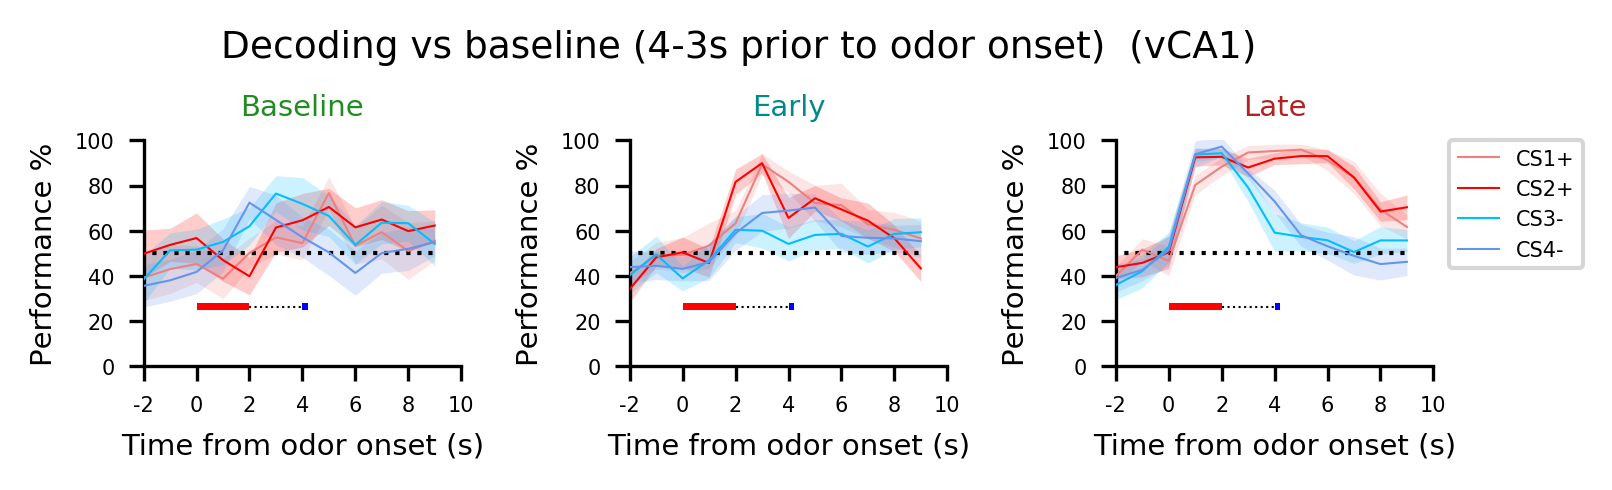

In [11]:
fig, ax = pl.subplots(1,3, figsize=(5, 1.5))

for comp,c,la in zip(['CS1','CS2','CS3','CS4'],['lightcoral','red','deepskyblue','cornflowerblue'],['CS1+','CS2+','CS3-','CS4-']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4) for t in range(14)], [(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (4-3s prior to odor onset)  (vCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

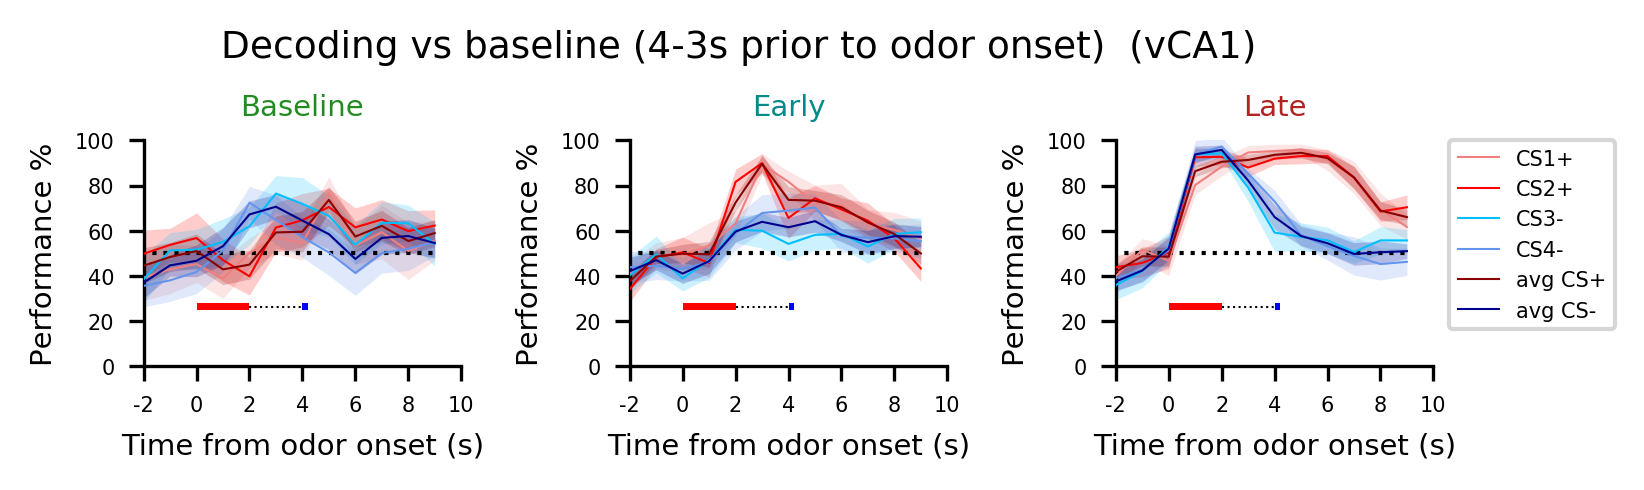

In [48]:
fig, ax = pl.subplots(1,3, figsize=(5, 1.5))

for comp,c,la in zip(['CS1','CS2','CS3','CS4','CSP_averaged','CSM_averaged'],['lightcoral','red','deepskyblue','cornflowerblue','darkred','darkblue'],['CS1+','CS2+','CS3-','CS4-','avg CS+','avg CS-']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4) for t in range(14)], [(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("baseline_scores_tb_%s_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-2, 9)
    ax[x].set_xticks(np.arange(-2,11, 2))
    ax[x].set_xticklabels(np.arange(-2,11, 2))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding vs baseline (4-3s prior to odor onset)  (vCA1)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)

#fig.savefig('../img/%s_3comp_horizontal.jpg'%NOTEBOOK_NAME)

In [49]:
save_workspace(db)

Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'ut'. Skipping...


# Now for equalizing cell #s across all sess by using min

#get number of vHPC cells used for decoding
cell_total = ['total_cells_expo_vHPC', 'total_cells_pre_vHPC', 'total_cells_post_vHPC']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_n_cells/')
    exec('%s = what'%(tot))
    print '%s ='%(tot),
    print what

#get number of dHPC cells used for decoding
cell_total = ['total_cells_expo_dHPC_2wayOnly', 'total_cells_pre_dHPC_2wayOnly', 'total_cells_post_dHPC_2wayOnly']
for tot in cell_total:
    what = ut.load_variable('%s'%(tot), '../notebooks/autorestore/decoding_n_cells/')
    exec('%s = what'%(tot))
    print '%s ='%(tot),
    print what

gmin = np.min((total_cells_pre_vHPC,total_cells_pre_dHPC, total_cells_post_vHPC,total_cells_post_dHPC,
                total_cells_expo_vHPC,total_cells_expo_dHPC))
print gmin

dmin = np.min((total_cells_pre_dHPC, total_cells_post_dHPC,total_cells_expo_dHPC))
print dmin

lmin =  np.min((total_cells_post_dHPC_2wayOnly, total_cells_post_vHPC))
print lmin

#get train and test subsamples for each timebin, for each session
relabel = {1:0,2:1,3:-1,4:-1}
n_loops=20
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS1vsCS2 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS1vsCS2"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:0,2:0,3:1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CSPvsCSM = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CSPvsCSM"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:0,2:-1,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS1vsCS3 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS1vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:0,2:-1,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS1vsCS4 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS1vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:-1,2:0,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS2vsCS3 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS2vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:-1,2:0,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS2vsCS4 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS2vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:-1,2:-1,3:0,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_gmin_CS3vsCS4 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_gmin_CS3vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=gmin, relabel=relabel) for i in range(n_loops)]]

%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
for t in range(14): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_gmin_outcome_%s = {}'%(t,it))
        n_loops = 20
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_gmin_outcome_%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,5), n_cells=gmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

%%time
tt_relabels_cont = [{1:0,2:1,3:-1,4:-1}]
tt_relabels_test_cont = [{1:-1,2:-1,3:0,4:1}]
for t in range(14): # number of time bins
    for re, rete, it in zip(tt_relabels_cont,tt_relabels_test_cont,['tr12_ts34']):
        exec('scores_tb_%s_gmin_outcome_%s = {}'%(t,it))
        n_loops = 20
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_gmin_outcome_%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,5), n_cells=gmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_gmin_CSPvsCSM_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_gmin_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_gmin_CS1vsCS3[sess],scores_tb_%s_gmin_CS1vsCS4[sess],\
              scores_tb_%s_gmin_CS2vsCS3[sess],scores_tb_%s_gmin_CS2vsCS4[sess]),axis=0)"%(t,t,t,t,t))

#for outcome endoding, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_gmin_outcome_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_gmin_outcome_averaged[sess] = np.mean((scores_tb_%s_gmin_outcome_tr13_ts24[sess],scores_tb_%s_gmin_outcome_tr14_ts23[sess],\
              scores_tb_%s_gmin_outcome_tr23_ts14[sess],scores_tb_%s_gmin_outcome_tr24_ts13[sess]),axis=0)"%(t,t,t,t,t))

fig, ax = pl.subplots(1,3, figsize=(7, 1.9))

for comp,c,la in zip(['CS1vsCS2','CS3vsCS4','CSPvsCSM'],['cyan','m','k'],['CS+ vs CS+','CS-  vs CS-','CS+ vs CS-']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
    pt.plot_period_bar(ax[x], 0, start_end=(4, 6), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Within and across CS classes (dCA1), gmin", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_horizontal_gmin.jpg'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(comparisons,comp_colors,comp_labels):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4) for t in range(14)], [(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_gmin_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("dCA1, all comparisons (global minimum cell count)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_6_gmin_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_6_gmin_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_6_gmin_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_6_gmin_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_6_gmin_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (dCA1, gmin)", fontsize=10, y=1)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_gmin_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_gmin_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_gmin_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_gmin_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_gmin_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_gmin_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace decoding accuracy (dCA1, gmin)", fontsize=10, y=1)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','tr12_ts34'],tt_colors,['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','tr12_ts34']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_gmin_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_gmin_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_gmin_outcome_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding Oucome dCA1, gmin (train on 1 CS+/CS- pair, test on other)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(4, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for comp,c,la,i in zip(tt_comparisons,tt_colors_k,['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average'],range(5)):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_gmin_outcome_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_gmin_outcome_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_gmin_outcome_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,4.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
#for r,sess in zip(range(3),sessions):
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],0,.9,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],
#                eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],1.1,2,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_gmin_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(tt_comparisons, range(len(tt_comparisons))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_gmin_outcome_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_gmin_outcome_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[1].set_title('Early', color = dark_co[1], y=1.)
ax[2].set_title('Late', color = dark_co[2], y=1.)
ax[2].legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding during trace (dCA1, gmin)", fontsize=10, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,2, figsize=(2.8, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
    for r,sess in zip(range(2),sessions[1:]):
        ax[r].bar(i,np.mean(eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k)))*100,width=.8,
                  color=c,alpha=.9,label=la,edgecolor='k')
        exec("s_%s_%s = np.array(np.std(scores_tb_%s_gmin_outcome_averaged[sess][:loops])*100)"%(k,sess,k))
        ax[r].errorbar(i,np.mean(eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k)))*100,yerr=eval('s_%s_%s'%(k,sess)),color='k')
for x in range (2):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,1.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess,q in zip(range(2),sessions[1:],[70,99]):
    pvs.append(add_significance(ax[r], scores_tb_6_gmin_outcome_averaged[sess][:loops],
                scores_tb_8_gmin_outcome_averaged[sess][:loops],0,1,q))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k))[:loops],.5,i,
#               np.mean(eval("scores_tb_%s_gmin_outcome_averaged[sess][:loops]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('Early', color = dark_co[1], y=1.03)
ax[1].set_title('Late', color = dark_co[2], y=1.03)
ax[0].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding (dCA1)", fontsize=9, y=1.1)

fig.tight_layout(w_pad=7)


fig.savefig('../img/%s_CSvsTr_outcome_decoding.pdf'%NOTEBOOK_NAME)

# decode using the minimum cells for late session 2wayOnly

#get train and test subsamples for each timebin, for each session
relabel = {1:0,2:1,3:-1,4:-1}
n_loops=20
for t in range(14): # number of time bins
    exec('scores_tb_%s_lmin_CS1vsCS2 = {}'%t)
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_lmin_CS1vsCS2"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=lmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:0,2:0,3:1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_lmin_CSPvsCSM = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_lmin_CSPvsCSM"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=lmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:0,2:-1,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_lmin_CS1vsCS3 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_lmin_CS1vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=lmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:0,2:-1,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_lmin_CS1vsCS4 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_lmin_CS1vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=lmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:-1,2:0,3:1,4:-1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_lmin_CS2vsCS3 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_lmin_CS2vsCS3"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=lmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:-1,2:0,3:-1,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_lmin_CS2vsCS4 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_lmin_CS2vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=lmin, relabel=relabel) for i in range(n_loops)]]

%%time
relabel = {1:-1,2:-1,3:0,4:1}
for t in range(14): # number of time bins
    exec('scores_tb_%s_lmin_CS3vsCS4 = {}'%t)
    n_loops = 20
    for sess in sessions:
        print sess,
        print t,
        eval("scores_tb_%s_lmin_CS3vsCS4"%t)[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
              classes=range(1,5), n_cells=lmin, relabel=relabel) for i in range(n_loops)]]

%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
for t in range(14): # number of time bins
    for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
        exec('scores_tb_%s_lmin_outcome_%s = {}'%(t,it))
        n_loops = 20
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_lmin_outcome_%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,5), n_cells=lmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

%%time
tt_relabels_cont = [{1:0,2:1,3:-1,4:-1}]
tt_relabels_test_cont = [{1:-1,2:-1,3:0,4:1}]
for t in range(14): # number of time bins
    for re, rete, it in zip(tt_relabels_cont,tt_relabels_test_cont,['tr12_ts34']):
        exec('scores_tb_%s_lmin_outcome_%s = {}'%(t,it))
        n_loops = 20
        for sess in sessions:
            print sess,
            print t,
            eval("scores_tb_%s_lmin_outcome_%s"%(t,it))[sess] = np.r_[[do_test_within(eval("patterns_tb_%s_%s"%(t,sess)),eval("labels_%s"%sess),
                  classes=range(1,5), n_cells=lmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for an alternative take on CS+ vs CS-, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_lmin_CSPvsCSM_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_lmin_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_lmin_CS1vsCS3[sess],scores_tb_%s_lmin_CS1vsCS4[sess],\
              scores_tb_%s_lmin_CS2vsCS3[sess],scores_tb_%s_lmin_CS2vsCS4[sess]),axis=0)"%(t,t,t,t,t))

#for outcome endoding, average each idividual comparison
for t in range(14):
    exec("scores_tb_%s_lmin_outcome_averaged = {}"%t)
    for sess in sessions:
        exec("scores_tb_%s_lmin_outcome_averaged[sess] = np.mean((scores_tb_%s_lmin_outcome_tr13_ts24[sess],scores_tb_%s_lmin_outcome_tr14_ts23[sess],\
              scores_tb_%s_lmin_outcome_tr23_ts14[sess],scores_tb_%s_lmin_outcome_tr24_ts13[sess]),axis=0)"%(t,t,t,t,t))

fig, ax = pl.subplots(1,3, figsize=(7, 1.9))

for comp,c,la in zip(['CS1vsCS2','CS3vsCS4','CSPvsCSM'],['cyan','m','k'],['CS+ vs CS+','CS-  vs CS-','CS+ vs CS-']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_lmin_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_lmin_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_lmin_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 0, start_end=(0, 2), color='k', delta_y=100,alpha=.09)
    pt.plot_period_bar(ax[x], 0, start_end=(4, 6), color='cornflowerblue', delta_y=100, alpha=.2)
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Within and across CS classes (dCA1), lmin", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


fig.savefig('../img/%s_3comp_horizontal_lmin.jpg'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(comparisons,comp_colors,comp_labels):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4) for t in range(14)], [(np.mean(eval("scores_tb_%s_lmin_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_lmin_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_lmin_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("dCA1, all comparisons (late minimum cell count)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=10
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_6_lmin_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_6_lmin_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_6_lmin_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_6_lmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_lmin_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_lmin_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_6_lmin_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_6_lmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_6_lmin_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_6_lmin_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_6_lmin_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("CS decoding accuracy (dCA1, lmin)", fontsize=10, y=1)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(4, 1.7))
loops=15
for comp,c,la,i in zip(alt_comparisons[:3],alt2_colors[:3],comp_labels[:3],range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_lmin_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_lmin_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_lmin_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,2.5, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess in zip(range(3),sessions):
    pvs.append(add_significance(ax[r], eval("scores_tb_8_lmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_lmin_%s[sess]"%(alt_comparisons[1]))[:loops],0,.9,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_lmin_%s[sess]"%(alt_comparisons[1]))[:loops],
                eval("scores_tb_8_lmin_%s[sess]"%(alt_comparisons[2]))[:loops],1.1,2,110))
    pvs.append(add_significance(ax[r], eval("scores_tb_8_lmin_%s[sess]"%(alt_comparisons[0]))[:loops],
                eval("scores_tb_8_lmin_%s[sess]"%(alt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(alt_comparisons[:3], range(len(alt_comparisons[:3]))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_lmin_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_lmin_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.2)
ax[1].set_title('Early', color = dark_co[1], y=1.2)
ax[2].set_title('Late', color = dark_co[2], y=1.2)
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Trace decoding accuracy (dCA1, lmin)", fontsize=10, y=1)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(6, 1.5))

for comp,c,la in zip(['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','tr12_ts34'],tt_colors,['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','tr12_ts34']):
    for r,sess in zip(range(3),sessions):
        ax[r].plot([(t-4.5) for t in range(14)], [(np.mean(eval("scores_tb_%s_lmin_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)],
                   color=c, ls='-',lw=.5, zorder=19 ,ms=1,label=la)
        m = np.array([(np.mean(eval("scores_tb_%s_lmin_outcome_%s[sess]"%(t,comp)))*100) for t in range(14)])
        s = np.array([np.std(eval("scores_tb_%s_lmin_outcome_%s[sess]"%(t,comp)))*100 for t in range(14)])
        ax[r].fill_between([(t-4.5) for t in range(14)],m-s,m+s,alpha=0.2,color=c,linewidth=0)
for x in range (3):
    ax[x].set_ylim(0, 100)
    ax[x].set_xlim(-5, 9)
    ax[x].set_xticks(np.arange(-5,11, 5))
    ax[x].set_xticklabels(np.arange(-5,11, 5))
    ax[x].hlines(50, -5,9, color='k', lw=1, linestyles='dotted')
    ax[x].set_xlabel('Time from odor onset (s)')
    ax[x].set_ylabel('Performance %')
    pt.plot_period_bar(ax[x], 25, start_end=(0, 2), color='r', delta_y=3)
# pt.plot_period_bar(ax, 25, start_end=(2, 4), color='0.7', delta_y=2)
    pt.plot_period_bar(ax[x], 25, start_end=(4, 4.2), color='b', delta_y=3)
    ax[x].hlines(25+1, 2, 4, color='k', lw=0.5, linestyles='dotted')
ax[0].set_title('Baseline', color=dark_co[0])
ax[1].set_title('Early', color = dark_co[1])
ax[2].set_title('Late', color = dark_co[2])
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Decoding Oucome dCA1, lmin (train on 1 CS+/CS- pair, test on other)", fontsize=9, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,3, figsize=(4, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for comp,c,la,i in zip(tt_comparisons,tt_colors_k,['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average'],range(5)):
    for r,sess in zip(range(3),sessions):
        ax[r].bar(i,np.mean(eval("scores_tb_8_lmin_outcome_%s[sess][:loops]"%(comp)))*100,width=.8, color=c,label=la)
        exec("s_%s_%s = np.array(np.std(scores_tb_8_lmin_outcome_%s[sess][:loops])*100)"%(comp,sess,comp))
        ax[r].errorbar(i,np.mean(eval("scores_tb_8_lmin_outcome_%s[sess][:loops]"%(comp)))*100,yerr=eval('s_%s_%s'%(comp,sess)),color='k')
for x in range (3):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,4.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
#for r,sess in zip(range(3),sessions):
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_lmin_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_lmin_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],0,.9,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_lmin_outcome_%s[sess]"%(tt_comparisons[1]))[:loops],
#                eval("scores_tb_8_lmin_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],1.1,2,110))
#    pvs.append(add_significance(ax[r], eval("scores_tb_8_lmin_outcome_%s[sess]"%(tt_comparisons[0]))[:loops],
#                eval("scores_tb_8_lmin_outcome_%s[sess]"%(tt_comparisons[2]))[:loops],0,2,119))
for comp,i in zip(tt_comparisons, range(len(tt_comparisons))):
    for r,sess in zip(range(3),sessions):
        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_8_lmin_outcome_%s[sess]"%(comp))[:loops],.5,i,
               np.mean(eval("scores_tb_8_lmin_outcome_%s[sess][:loops]"%(comp)))*100+(eval("s_%s_%s"%(comp,sess)))+1,loops=loops,sig_func=None,colors='k'))

ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[1].set_title('Early', color = dark_co[1], y=1.)
ax[2].set_title('Late', color = dark_co[2], y=1.)
ax[2].legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding during trace (dCA1, lmin)", fontsize=10, y=1.05)

fig.tight_layout(pad=2)


#fig.savefig('../img/%s_CSPvsCSM_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1,2, figsize=(2.8, 1.5))
loops=15
tt_comparisons =['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
    for r,sess in zip(range(2),sessions[1:]):
        ax[r].bar(i,np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][:loops]"%(k)))*100,width=.8,
                  color=c,alpha=.9,label=la,edgecolor='k')
        exec("s_%s_%s = np.array(np.std(scores_tb_%s_lmin_outcome_averaged[sess][:loops])*100)"%(k,sess,k))
        ax[r].errorbar(i,np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][:loops]"%(k)))*100,yerr=eval('s_%s_%s'%(k,sess)),color='k')
for x in range (2):
    ax[x].set_ylim(0, 100)
    #ax[x].set_xlim(-5, 9)
    ax[x].hlines(50, -0.5,1.7, color='k', lw=1, linestyles='dotted')
    #ax[x].set_xlabel('Comparison')
    ax[x].set_ylabel('Performance %')
    ax[x].tick_params(axis='x',bottom='off',labelbottom='off')

pvs=[]
for r,sess,q in zip(range(2),sessions[1:],[70,99]):
    pvs.append(add_significance(ax[r], scores_tb_6_lmin_outcome_averaged[sess][:loops],
                scores_tb_8_lmin_outcome_averaged[sess][:loops],0,1,q))
#for i,k,c,la in zip(range(2),[6,8],['lightgrey','k'],['CS','Trace']):
#    for r,sess in zip(range(2),sessions[1:]):
#        pvs.append(sig_vs_chance(ax[r],eval("scores_tb_%s_lmin_outcome_averaged[sess][:loops]"%(k))[:loops],.5,i,
#               np.mean(eval("scores_tb_%s_lmin_outcome_averaged[sess][:loops]"%(k)))*100+(eval("s_%s_%s"%(k,sess)))+1,loops=loops,sig_func=None,colors='k'))

#ax[0].set_title('Baseline', color=dark_co[0], y=1.)
ax[0].set_title('Early', color = dark_co[1], y=1.03)
ax[1].set_title('Late', color = dark_co[2], y=1.03)
ax[0].legend(bbox_to_anchor=(.97, 1), loc='upper left', borderaxespad=0.)
pl.suptitle("Outcome decoding (dCA1)", fontsize=9, y=1.1)

fig.tight_layout(w_pad=7)


fig.savefig('../img/%s_CSvsTr_outcome_decoding.pdf'%NOTEBOOK_NAME)

# And now for decoding across time bins! (using distinct trials for train/test)

def combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns_train.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns_train.copy()
    labels_t = labels.copy()
    for ani in patterns_train.keys():
        patterns_t[ani] = patterns_train[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns_test.copy()
        labels_T = labels.copy()
        for ani in patterns_test.keys():
            patterns_T[ani] = patterns_test[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if train_test_split<1:
        if relabel_test is not None:
            labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
        else:
            if relabel is not None:
                labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
            else:
                labels_comb_test = labels_comb_test_
    elif train_test_split == 1:
        labels_comb_test = None
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test
    
    if train_test_split<1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
    if train_test_split == 1:
        return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
                None,None)

def do_test_across_tbs(patterns_train, patterns_test, labels, **args):
    x, y, xT, yT = combine_train_test_patterns_across_tbs(patterns_train, patterns_test, labels, train_test_split=0.5, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

### running the cell below will take over an hour!

%%time
n_loops=15
for t in range (14):
    for c in range (14):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s = {}'%(t,c,comp))
            for sess in sessions:
                print sess,t,c,comp,
                print " ",
                eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=None, relabel=relab) for i in range(n_loops)]]

%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
n_loops=15
for t in range (14):
    for c in range (14):
        for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
            exec('scores_tb_%s_VS_%s_outcome_%s = {}'%(t,c,it))
            for sess in sessions:
                print sess,t,c,it,
                print " ",
                eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,it))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=None, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_outcome_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_outcome_averaged[sess] = np.mean((scores_tb_%s_VS_%s_outcome_tr13_ts24[sess],\
                 scores_tb_%s_VS_%s_outcome_tr14_ts23[sess],scores_tb_%s_VS_%s_outcome_tr23_ts14[sess],\
                 scores_tb_%s_VS_%s_outcome_tr24_ts13[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4[sess],scores_tb_%s_VS_%s_CS2vsCS3[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in comparisons_av:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

for comp in comparisons_av:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

session_labels = ('Baseline','Early','Late')

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(7,7.4,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: CS+ vs CS-',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(8, 3, figsize=(6, 21))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(comparisons_av,range(len(comparisons_av))):
        im = ax[i][x].imshow(eval("distinct_%s[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,comp_labels_av[i],fontsize=11)

import matplotlib.patches as patches
for i in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance',y=1.02,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE.jpg'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Decoding p-values CS+ vs CS- (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

tt_pairs_avg = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
tt_labels = ['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average']

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_outcome_%s'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_wilcox = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_wilcox[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_outcome_%s[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in tt_pairs_avg:
    exec("distinct_%s={}"%comp)
    for sess in sessions:
        exec("distinct_%s[sess]=(distinct0_%s[sess], distinct1_%s[sess], distinct2_%s[sess], distinct3_%s[sess], distinct4_%s[sess], distinct5_%s[sess], distinct6_%s[sess], distinct7_%s[sess],\
              distinct8_%s[sess], distinct9_%s[sess], distinct10_%s[sess], distinct11_%s[sess], distinct12_%s[sess],\
              distinct13_%s[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s[sess]"%comp)])

for comp in tt_pairs_avg:
    exec("distinct_%s_wilcox={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox[sess]=(distinct0_%s_wilcox[sess], distinct1_%s_wilcox[sess], distinct2_%s_wilcox[sess], distinct3_%s_wilcox[sess], distinct4_%s_wilcox[sess], distinct5_%s_wilcox[sess], distinct6_%s_wilcox[sess], distinct7_%s_wilcox[sess],\
              distinct8_%s_wilcox[sess], distinct9_%s_wilcox[sess], distinct10_%s_wilcox[sess], distinct11_%s_wilcox[sess], distinct12_%s_wilcox[sess],\
              distinct13_%s_wilcox[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox[sess]"%comp)])

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: Outcome',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(5, 3, figsize=(6, 15))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
        im = ax[i][x].imshow(eval("distinct_%s[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,tt_labels[i],fontsize=11)

import matplotlib.patches as patches
for i in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Outcome Decoding Performance',y=1.,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 5, figsize=(11, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1.5,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(7.1,7.4,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Outcome Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_wilcox[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Outcome Decoding p-values (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 5, figsize=(8, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_wilcox['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

# now downsample cells to late session minimum (lmin)

%%time
n_loops=15
for t in range (14):
    for c in range (14):
        for comp,relab in zip(comparisons,relabels):
            exec('scores_tb_%s_VS_%s_%s_lmin = {}'%(t,c,comp))
            for sess in sessions:
                print sess,t,c,comp,
                print " ",
                eval('scores_tb_%s_VS_%s_%s_lmin'%(t,c,comp))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=lmin, relabel=relab) for i in range(n_loops)]]

%%time
tt_relabels = [{1:0,2:-1,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:-1,2:0,3:-1,4:1}]
tt_relabels_test = [{1:-1,2:0,3:-1,4:1}, {1:-1,2:0,3:1,4:-1}, {1:0,2:-1,3:-1,4:1}, {1:0,2:-1,3:1,4:-1}]
tt_pairs = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13']
n_loops=15
for t in range (14):
    for c in range (14):
        for re, rete, it in zip(tt_relabels,tt_relabels_test,tt_pairs):
            exec('scores_tb_%s_VS_%s_outcome_%s_lmin = {}'%(t,c,it))
            for sess in sessions:
                print sess,t,c,it,
                print " ",
                eval('scores_tb_%s_VS_%s_outcome_%s_lmin'%(t,c,it))[sess] = np.r_[[do_test_across_tbs(eval('patterns_tb_%s_%s'%(t,sess)),
                      eval('patterns_tb_%s_%s'%(c,sess)),eval('labels_%s'%sess),classes=range(1,5),
                      n_cells=lmin, relabel=re, relabel_test=rete) for i in range(n_loops)]]

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_outcome_averaged_lmin = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_outcome_averaged_lmin[sess] = np.mean((scores_tb_%s_VS_%s_outcome_tr13_ts24_lmin[sess],\
                 scores_tb_%s_VS_%s_outcome_tr14_ts23_lmin[sess],scores_tb_%s_VS_%s_outcome_tr23_ts14_lmin[sess],\
                 scores_tb_%s_VS_%s_outcome_tr24_ts13_lmin[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

#for outcome endoding, average each idividual comparison
for t in range(14):
    for c in range(14):
        exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_lmin = {}"%(t,c))
        for sess in sessions:
            exec("scores_tb_%s_VS_%s_CSPvsCSM_averaged_lmin[sess] = np.mean((scores_tb_%s_VS_%s_CS1vsCS3_lmin[sess],\
                 scores_tb_%s_VS_%s_CS1vsCS4_lmin[sess],scores_tb_%s_VS_%s_CS2vsCS3_lmin[sess],\
                 scores_tb_%s_VS_%s_CS2vsCS4_lmin[sess]),axis=0)"%(t,c,t,c,t,c,t,c,t,c))

comparisons_av = ['CSPvsCSM','CS1vsCS2','CS3vsCS4','CS1vsCS3','CS1vsCS4','CS2vsCS3','CS2vsCS4','CSPvsCSM_averaged']
comp_labels_av = ['CS+ vs CS-','CS+ vs CS+','CS-  vs CS-','CS1+ vs CS3-','CS1+ vs CS4-','CS2+ vs CS3-','CS2+ vs CS4-','CS+ vs CS- avg']

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s_lmin['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s_lmin'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_%s_lmin'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in comparisons_av:
        exec('distinct%s_%s_wilcox_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in comparisons_av:
            exec("distinct%s_%s_wilcox_lmin[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_%s_lmin[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox_lmin[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in comparisons_av:
    exec("distinct_%s_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_lmin[sess]=(distinct0_%s_lmin[sess], distinct1_%s_lmin[sess], distinct2_%s_lmin[sess], distinct3_%s_lmin[sess], distinct4_%s_lmin[sess], distinct5_%s_lmin[sess], distinct6_%s_lmin[sess], distinct7_%s_lmin[sess],\
              distinct8_%s_lmin[sess], distinct9_%s_lmin[sess], distinct10_%s_lmin[sess], distinct11_%s_lmin[sess], distinct12_%s_lmin[sess],\
              distinct13_%s_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_lmin[sess]"%comp)])

for comp in comparisons_av:
    exec("distinct_%s_wilcox_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox_lmin[sess]=(distinct0_%s_wilcox_lmin[sess], distinct1_%s_wilcox_lmin[sess], distinct2_%s_wilcox_lmin[sess], distinct3_%s_wilcox_lmin[sess], distinct4_%s_wilcox_lmin[sess], distinct5_%s_wilcox_lmin[sess], distinct6_%s_wilcox_lmin[sess], distinct7_%s_wilcox_lmin[sess],\
              distinct8_%s_wilcox_lmin[sess], distinct9_%s_wilcox_lmin[sess], distinct10_%s_wilcox_lmin[sess], distinct11_%s_wilcox_lmin[sess], distinct12_%s_wilcox_lmin[sess],\
              distinct13_%s_wilcox_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox_lmin[sess]"%comp)])

session_labels = ('Baseline','Early','Late')

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(7,7.4,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance (lmin): CS+ vs CS-',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(8, 3, figsize=(6, 21))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(comparisons_av,range(len(comparisons_av))):
        im = ax[i][x].imshow(eval("distinct_%s_lmin[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,comp_labels_av[i],fontsize=11)

import matplotlib.patches as patches
for i in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance (lmin)',y=1.02,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='k',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='k',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)
    ax[x].text(4.2,-2.5,'Tested on',fontsize=12,color='darkslateblue')

ax[0].text(-2.9,11,'Trained on',rotation=90,fontsize=12,color='darkslateblue')
ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='k')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='k')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Decoding Performance (lmin): Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
fig.savefig('../img/%s_across_bins_LATE_lmin.jpg'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_CSPvsCSM_wilcox_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Decoding p-values CS+ vs CS- (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 8, figsize=(13, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(comparisons_av,range(len(comparisons_av))):
    im = ax[x].imshow(eval("distinct_%s_wilcox_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (8):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(comp_labels_av[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(8):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

tt_pairs_avg = ['tr13_ts24','tr14_ts23','tr23_ts14','tr24_ts13','averaged']
tt_labels = ['1v3 & 2v4','1v4 & 2v3','2v3 & 1v4','2v4 & 1v3','Average']

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_lmin['%s'] = []"%(t,comp,sess))
            for c in range (14):
                eval('distinct%s_%s_lmin'%(t,comp))[sess].insert(c,(eval('scores_tb_%s_VS_%s_outcome_%s_lmin'%(t,c,comp))[sess].mean()))

for t in range (14):
    for comp in tt_pairs_avg:
        exec('distinct%s_%s_wilcox_lmin = {}'%(t,comp))
for sess in sessions:
    for t in range (14):
        for comp in tt_pairs_avg:
            exec("distinct%s_%s_wilcox_lmin[sess] = []"%(t,comp))
            for c in range (14):
                exec("subtracted = [x-0.5 for x in scores_tb_%s_VS_%s_outcome_%s_lmin[sess]]"%(t,c,comp))
                eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess].insert(c, sstats.wilcoxon(subtracted[:15]))
            for x,i in zip(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess],range(len(eval('distinct%s_%s_wilcox_lmin'%(t,comp))[sess]))):
                exec("distinct%s_%s_wilcox_lmin[sess][i] = x[-1]"%(t,comp)) #only take p-values

for comp in tt_pairs_avg:
    exec("distinct_%s_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_lmin[sess]=(distinct0_%s_lmin[sess], distinct1_%s_lmin[sess], distinct2_%s_lmin[sess], distinct3_%s_lmin[sess], distinct4_%s_lmin[sess], distinct5_%s_lmin[sess], distinct6_%s_lmin[sess], distinct7_%s_lmin[sess],\
              distinct8_%s_lmin[sess], distinct9_%s_lmin[sess], distinct10_%s_lmin[sess], distinct11_%s_lmin[sess], distinct12_%s_lmin[sess],\
              distinct13_%s_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_lmin[sess]"%comp)])

for comp in tt_pairs_avg:
    exec("distinct_%s_wilcox_lmin={}"%comp)
    for sess in sessions:
        exec("distinct_%s_wilcox_lmin[sess]=(distinct0_%s_wilcox_lmin[sess], distinct1_%s_wilcox_lmin[sess], distinct2_%s_wilcox_lmin[sess], distinct3_%s_wilcox_lmin[sess], distinct4_%s_wilcox_lmin[sess], distinct5_%s_wilcox_lmin[sess], distinct6_%s_wilcox_lmin[sess], distinct7_%s_wilcox_lmin[sess],\
              distinct8_%s_wilcox_lmin[sess], distinct9_%s_wilcox_lmin[sess], distinct10_%s_wilcox_lmin[sess], distinct11_%s_wilcox_lmin[sess], distinct12_%s_wilcox_lmin[sess],\
              distinct13_%s_wilcox_lmin[sess])"%(comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp,comp))
        np.array([eval("distinct_%s_wilcox_lmin[sess]"%comp)])

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='lightgray')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgray')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Decoding Performance: Outcome',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(5, 3, figsize=(6, 15))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    for comp,i in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
        im = ax[i][x].imshow(eval("distinct_%s_lmin[sess]"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
        ax[i][x].set_xticks(range(14))
        ax[i][x].set_yticks(range(14))
        ax[i][x].set_ylim(2.5,13.5)
        ax[i][x].set_xlim(2.5,13.5)
        ax[i][x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
        ax[i][x].set_ylabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_xlabel('Time from CS onset (s)', fontsize=7)
        ax[i][x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
        ax[i][x].tick_params(length=3)
        ax[i][1].text(5,16,tt_labels[i],fontsize=11)

import matplotlib.patches as patches
for i in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[i][0].add_patch(CS)
    ax[i][0].add_patch(Tr)
    ax[i][0].text(4.85,5.2,"CS",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(6.85,7.15,"Tr",fontsize=8, weight='bold', color='lightgray')
    ax[i][0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgray')

pl.suptitle('dCA1 Outcome Decoding Performance',y=1.,fontsize=15)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

fig, ax = pl.subplots(1, 5, figsize=(11, 3))#, sharex=True, sharey=True)
vmin=0.5
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap='afmhot')
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1.5,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(5,5.3,"CS",fontsize=8, weight='bold', color='w')
ax[0].text(7.1,7.4,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='k')

pl.suptitle('dCA1 Outcome Decoding Performance: Late Session',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 3, figsize=(6, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for sess,x in zip(sessions,range(len(sessions))):
    im = ax[x].imshow(distinct_averaged_wilcox_lmin[sess],origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (3):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(session_labels[x],fontsize=10,color=dark_co[x])
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(3):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='w')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='dimgrey')

pl.suptitle('dCA1 Outcome Decoding p-values (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='p-value')#,ticks=[0,.05,.1])
#cax.axes.set_ylim(0,.1)
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal_wilcoxon.pdf'%NOTEBOOK_NAME)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#make unique colormap for emphasizing significant p-values
sigs = cm.get_cmap('BuPu', 15)
white = np.array([1, 1, 1, 1])
newcolors = np.vstack((sigs(np.linspace(1, 0, 15)),
                       sigs(np.linspace(0, 1, 241))))
#pink = np.array([.96, .09, .6, 1])
newcolors[15:, :] = white
newcmap = ListedColormap(newcolors)

fig, ax = pl.subplots(1, 5, figsize=(8, 3))#, sharex=True, sharey=True)
vmin=0
vmax=1
for comp,x in zip(tt_pairs_avg,range(len(tt_pairs_avg))):
    im = ax[x].imshow(eval("distinct_%s_wilcox_lmin['post']"%comp),origin='lower', interpolation='nearest', vmin=vmin, vmax=vmax,cmap=newcmap)
for x in range (5):
    ax[x].set_xticks(range(14))
    ax[x].set_yticks(range(14))
    ax[x].set_ylim(2.5, 13.5)
    ax[x].set_xlim(2.5,13.5)
    ax[x].set_xticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_yticklabels(['-5\nto\n-4','-4\nto\n-3','-3','-2','-1','0','1','2','3','4','5', '6','7','8','9','10'],fontsize=6)
    ax[x].set_ylabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_xlabel('Time from CS onset (s)', fontsize=7)
    ax[x].set_title(tt_labels[x],fontsize=10,color='k')
    ax[x].tick_params(length=3)

import matplotlib.patches as patches
for x in range(5):
# Create a Rectangle patch
    CS = patches.Rectangle((4.5,4.5),2,2,linewidth=1,edgecolor='w',facecolor='none')
    Tr = patches.Rectangle((6.5,6.5),2,2,linewidth=1,edgecolor='w',facecolor='none',linestyle=':')
# Add the patch to the Axes
    ax[x].add_patch(CS)
    ax[x].add_patch(Tr)

ax[0].text(4.75,5.1,"CS",fontsize=8, weight='bold', color='dimgrey')
ax[0].text(6.85,7.1,"Tr",fontsize=8, weight='bold', color='lightgrey')
ax[0].text(8.6,8.8,"US",fontsize=8, weight='bold', color='lightgrey')

pl.suptitle('dCA1 Decoding p-values: Late session (Wilcoxon vs chance)',y=.93,fontsize=13)

cax = fig.add_axes([1,0.3, 0.01, 0.4])
fig.colorbar(im, cax=cax, label='Decoding perf. (%)')
fig.tight_layout(pad=1.5)
#fig.savefig('../img/%s_gmin_across_bins_distinct_horizontal.pdf'%NOTEBOOK_NAME)